# Lecture 5
Serialization of data and use of external application API (Application Programmable Interface)

Often Python scripts are used to process data in consequence creating new data for further use. The processing part can itself be computationally involving and being able to store data in the easily accessible form is very convenient. Especially so if the processing part takes days (but even hours) and access to data is required at some latter stages of the project. One, obvious solution is to store resulting data in simple CSV type files, but this approach is limited, especially if data structure becomes complex.
For example, we might be storing time history of velocity profiles $(u,v,w)$ through a flow field retrieved from a number of locations and performed across snapshots in time ... . In general we have a lot of complex data to deal with, and would like to store it in some organized manner, to be retrieved and worked on latter. For this we can use **serialization**, which in the simplest terms means to store data. The concept comes from the need to communicate different application forming a system and working possibly across different platforms (or simply form game saves ...).

Here we will illustrate how to **store** and **retrieve** data we process and produce. Consider a process where we have a number of snapshots from computations (data could be data from experiments) describing some arbitrary vector field in time (or positions of a robot, some mappings of its surroundings, readings from sensors etc.). We will store such data within objects of the following class:

In [ ]:
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
class Case:
    def __init__(self, fname):
        self.file_name = fname # File name from which we will read
        
        self.time = 0 # solution time
        self.number_of_pointst = 0 # number of data points

        # position of the profile cut
        self.profile_pos = np.array([0.0,0.0,0.0], dtype=float)

        self.Y = np.array # Y coordinate
        self.u = np.array # Components of velocity acros Y
        self.v = np.array
        self.w = np.array

So we have a simple class that will hold $(u,v,w)$ components of a vector obtained at $time$ and at a point with $Y$ the coordinate across the cut. Lets now populate it with some made up data:

In [ ]:
clist = []
c = Case("file_0.dat") # some file we read from
c.time = 0
c.number_of_pointst = 1000
c.profile_pos[0] = 5 # move at x=5
c.profile_pos[1] = 10 # move at y=5
c.Y = np.linspace(-1,1,100)
# Normally u,v,w are read from file, here made up
c.u = 1-c.Y**2
c.v = c.Y * 0
c.w = c.Y * 0
clist.append(c) # add to a list

In [ ]:
plt.plot(c.u, c.Y)

Let have a second one:

In [ ]:
c = Case("file_1.dat") # some file we read from
c.time = 1
c.number_of_pointst = 1000
c.profile_pos[0] = 5 # move at x=5
c.profile_pos[1] = 10 # move at y=5
c.Y = np.linspace(-1,1,100)
# Normally u,v,w are read from file, here made up
c.u = 1-c.Y**3
c.v = c.Y * 0
c.w = c.Y * 0
clist.append(c) # add to a list

In [ ]:
for c in clist:
    plt.plot(c.u, c.Y)
plt.xlim(0,2)
plt.ylim(-1,1)
plt.grid()

usually there will be more data, the structure might be more complex, or some additional process will be used to do something with the data etc.

For data storage we will use the `msgpack`, which is a serialization format for use in data exchange across different languages, but not only. Here is the project:  
https://github.com/msgpack/msgpack-python  
and its API documentation:  
https://msgpack-python.readthedocs.io/en/latest/api.html  

In short, hands on How to Use we will require an instruction on how to handle data. How to encode and pack it and how to unpack and decode it. So we need to add encoding as well as decoding functions. Those function will accept an object of our data storage class and inform `msgpack` what to do with it. The whole process is in fact quite simple. We just do:

In [ ]:
import msgpack

To import an appropriate module, and:

In [ ]:
clist[0].profile_pos

In [ ]:
"""Encoding function"""
def enc_full(obj):
    if type(obj) == Case: # make sure obj is of some type
        code = 1 # A flag determining the type
        # pack and return
        return msgpack.ExtType(code,
            msgpack.packb([obj.file_name, obj.time,
                           obj.number_of_pointst,
                           obj.profile_pos.tobytes(),
                           obj.Y.tobytes(),
                           obj.u.tobytes(), obj.v.tobytes(),
                           obj.w.tobytes()]))
    raise TypeError # Rise an error if type not handled

And we have the encoding part. Now, all simple data types go as they are (file_name, time ...) and Numpy arrays need to be converted to strings (either the `tostring` or `tobytes` methods). The `packb` simply packs an object into an appropriate format. One comment here is that we are not packing the `Case` object itself, but rather a list (note `[ ]`) of attributes such object has. The `code` identifies the stored type, since we could have more than one class to deal with the `code` would let us distinguish recovered data.
We can now store this data to a file, simply with:

In [ ]:
ls

In [ ]:
msgpack.dump(clist, open( 'bbb.dat', "wb" ), default=enc_full)

The `"wb"` lets us store this data in binary format. We will need to recover the data appropriatly with `"rb"`. See if the file was created, and look inside.

Now restart the Python interpreter and try to recover the data we put on disk. The `Case` class still needs to be defined, so in case you restarted the interpreter, do run the appropriate cell above that defines the class.  
To decode we will need a decoding function. It will contain instructions on how to rebuild objects from storage, create an object, feed it with data and return:

In [ ]:
import msgpack
import numpy as np
from matplotlib import pyplot as plt

In [ ]:
def dnc(code, data):
    if code == 1: # a flag determining the type
        # call the unpack on the data passed in here
        file_name, time, num_pts, pos, Y, u, v, w = msgpack.unpackb(data)
        
        # make the object
        c = Case(file_name)
        
        # feed it with data
        c.time = time
        c.number_of_pointst = num_pts
        # Note that numpy arrays need to be handled in a speciall way
        c.profile_pos = np.frombuffer(pos)
        c.Y = np.frombuffer(Y)
        c.u = np.frombuffer(u)
        c.v = np.frombuffer(v)
        c.w = np.frombuffer(w)
        
        # return the object outside
        return c
    # in case the type is either a build in or other
    return msgpack.ExtType(code, data)

We have just one class, and its code is simply `1`. `dnc()` will be passed this `code` as well as the binary data, which will be unpacked and returned as a tuple.
It is up to us to create a new object and populate it with data and than to return it.

Lifting data from storage is now simple. Note that we need to pass the decoding function to be used by `load()`, the file name and `"rb"` since we read binary data:

In [ ]:
ls

In [ ]:
recovered_list = msgpack.load(open( 'bbb.dat', "rb" ), ext_hook=dnc)

Now a copy of our data should be in `recovered_list`:

In [ ]:
for c in recovered_list:
    plt.plot(c.u, c.Y)
plt.xlim(0,2)
plt.ylim(-1,1)
plt.grid()

## Working with API
Various application provide some form of interface to interact with it. Python API becomes more and more a standard. How to connect to, how to use and to what it might be beneficial is very much problem dependant. For this I decided to show you connection to the Open Source visualization package ParaView. I use it to visualize CFD data, but it also used in other fields of engineering.

So the first step is to get your hands on the API, it will come as a Python module, it might need to be compiled, or be available as a software package. Here, I have the module compiled to a library placed in `/opt/paraview/lib/python3.8/`. Also I know I will need some of the Numpy functionality to process data:

In [2]:
import sys
sys.path.append('/home/sgepner/Data/Projekty/Software/ParaView-5.10.1-MPI-Linux-Python3.9-x86_64/lib/python3.9/site-packages/')
sys.path.append('/home/sgepner/Data/Projekty/Software/ParaView-5.10.1-MPI-Linux-Python3.9-x86_64/lib/python3.9/')
sys.path.append('/home/sgepner/Data/Projekty/Software/ParaView-5.10.1-MPI-Linux-Python3.9-x86_64/lib/')

In [3]:
from paraview.simple import *
from paraview.numeric import fromvtkarray

In [4]:
import numpy as np

# from vtk.util.numpy_support import vtk_to_numpy
# from vtk.numpy_interface import dataset_adapter as dsa
# from vtk.numpy_interface import algorithms as algs

import matplotlib.pyplot as plt

In [5]:
paraview.simple.GetParaViewVersion()

(5, 10)

What can be done with the API is very much up to the providing application and the level of documentation. In the case of Open Source project documentation is often lacking. This is the case with ParaView (was some time ago, could be better now). In what follows I will load a flow field snapshot and plot velocity profiles at selected positions:

### 1. Read the data

In [6]:
geom = XMLUnstructuredGridReader(FileName=['geom_4000.vtu'])
geom.PointArrayStatus = ['u', 'v', 'w']

In [ ]:
plot_over_line = PlotOverLine(Input=geom)

In [ ]:
plot_over_line.Point1 = [0.0, -1.0, 12.0]
plot_over_line.Point2 = [0.0, 1.0, 12.0]

In [ ]:
pl = servermanager.Fetch(plot_over_line)

In [ ]:
print(pl.GetPoints().GetData())

In [ ]:
fromvtkarray(pl.GetPoints().GetData())

In [ ]:
pos = fromvtkarray(pl.GetPoints().GetData())

In [ ]:
type(pos)

In [ ]:
print(pl.GetPointData().GetScalars('w'))

In [ ]:
a = fromvtkarray(pl.GetPointData().GetScalars("u"))
print(a.shape)
a = np.hstack([val for val in a])
print(a.shape)
print(a)

In [ ]:
valsU = fromvtkarray(pl.GetPointData().GetScalars("u"))
valsU = np.hstack([val for val in valsU])

In [ ]:
valsV = fromvtkarray(pl.GetPointData().GetScalars("v"))
valsV = np.hstack([val for val in valsV])
valsW = fromvtkarray(pl.GetPointData().GetScalars("w"))
valsW = np.hstack([val for val in valsW])

And here we have velocity components and positions, just what we need to make a nice plot. One of the things that one may, or not learn from documentation is that `pos` contains a transposed coordinates:

In [ ]:
plt.plot(pos.T[1], valsU)
plt.plot(pos.T[1], valsV)
plt.grid()

In [ ]:
plt.plot(pos.T[1], valsW)
plt.grid()

We can modify the direction data is taken from:

In [ ]:
plot_over_line.Point1 = [0.0, 0.0, 0.0]
plot_over_line.Point2 = [0.0, 0.0, 25.13]

In [ ]:
pl = servermanager.Fetch(plot_over_line)

pos = fromvtkarray(pl.GetPoints().GetData())
valsU = fromvtkarray(pl.GetPointData().GetScalars("u"))
valsU = np.hstack([val for val in valsU])
valsV = fromvtkarray(pl.GetPointData().GetScalars("v"))
valsV = np.hstack([val for val in valsV])
valsW = fromvtkarray(pl.GetPointData().GetScalars("w"))
valsW = np.hstack([val for val in valsW])

Now plotting along $z$ coordinate:

In [ ]:
plt.plot(pos.T[2], valsW)
plt.grid()

### 2. Perform more complex operations
Now we will try to recover a number of velocity profiles and store them, for later use using serialization.

1. Define what data you want to store, and design an appropriate storage class

In [ ]:
class Case:
    def __init__(self, fname):
        self.file_name = fname # File name from which we will read
        
        self.profile_pos = 0 # position along z-direction

        self.Y = np.array # Y coordinate
        self.u = np.array # Components of velocity acros Y
        self.v = np.array
        self.w = np.array

In [5]:
geom = XMLUnstructuredGridReader(FileName=['geom_4000.vtu'])
geom.PointArrayStatus = ['u', 'v', 'w']

plot_over_line = PlotOverLine(Input=geom)

In [ ]:
clist = []
for z in np.arange(0.1, 25, 1):
    c = Case('geom.plt')
    plot_over_line.Point1 = [0.0, -1.0, z]
    plot_over_line.Point2 = [0.0, 1.0, z]
    c.profile_pos = z

    pl = servermanager.Fetch(plot_over_line)

    pos = fromvtkarray(pl.GetPoints().GetData())
    
    valsU = fromvtkarray(pl.GetPointData().GetScalars("u"))
    valsU = np.hstack([val for val in valsU])
    valsV = fromvtkarray(pl.GetPointData().GetScalars("v"))
    valsV = np.hstack([val for val in valsV])
    valsW = fromvtkarray(pl.GetPointData().GetScalars("w"))
    valsW = np.hstack([val for val in valsW])
    
    c.Y = np.array([p[1] for p in pos])
    c.u = valsU
    c.v = valsV
    c.w = valsW
    clist.append(c)

In [ ]:
z = pos[0][2]
y = np.array([p[1] for p in pos])
print(z, y)

In [ ]:
print(len(clist))

In [ ]:
fig = plt.figure(figsize=(10,5))
for i,c in enumerate(clist):
    plt.plot(c.w+[0.1*i], c.Y)
plt.ylim(-1,1)
plt.grid()

Add the encoding / decoding functions and store / lad the data

## Externally process data
Using ParaView API we will attept to generate some nice looking, publication ready figures.

In [7]:
# create a new 'Slice'
slice1 = Slice(registrationName='Slice1', Input=geom)
slice1.SliceType = 'Plane'
slice1.HyperTreeGridSlicer = 'Plane'
slice1.SliceOffsetValues = [0.0]

# init the 'Plane' selected for 'SliceType'
slice1.SliceType.Origin = [0.0, 0.0, 12.566370964050293]

# init the 'Plane' selected for 'HyperTreeGridSlicer'
slice1.HyperTreeGridSlicer.Origin = [0.0, 0.0, 12.566370964050293]

# Properties modified on slice1.SliceType
slice1.SliceType.Normal = [0.0, 0.0, 1.0]

In [8]:
a = slice1.PointData.values()
print(a)

[Array: u, Array: v, Array: w]


In [9]:
slice_lok = paraview.servermanager.Fetch(slice1)

In [10]:
print(slice_lok.GetNumberOfCells())
print(slice_lok.GetNumberOfPoints())

4232
2304


In [11]:
point_coords = fromvtkarray(slice_lok.GetPoints().GetData())
slice_data = slice_lok.GetPointData()

In [12]:
w = fromvtkarray(slice_data.GetScalars('w'))
print(w.shape)
w = w[:,0]
print(w.shape)

(2304, 1)
(2304,)


In [13]:
npts = len(point_coords)
print(len(point_coords))
print(len(w))

2304
2304


In [14]:
x = np.zeros(npts)
y = np.zeros(npts)

for i in xrange(npts):
    pt = point_coords[i]
    x[i] = pt[0]
    y[i] = pt[1]

Data Loaded to three arrays for point position (x,y) and the value of interest. Note the problem with API consistency. See an example at the end.

In [15]:
print(x.shape, y.shape, w.shape)

(2304,) (2304,) (2304,)


Now, we will try to plot the velocity profile at the section:

## 1 
`plot_trisurf()` - plot triangulated surface

<IPython.core.display.Javascript object>


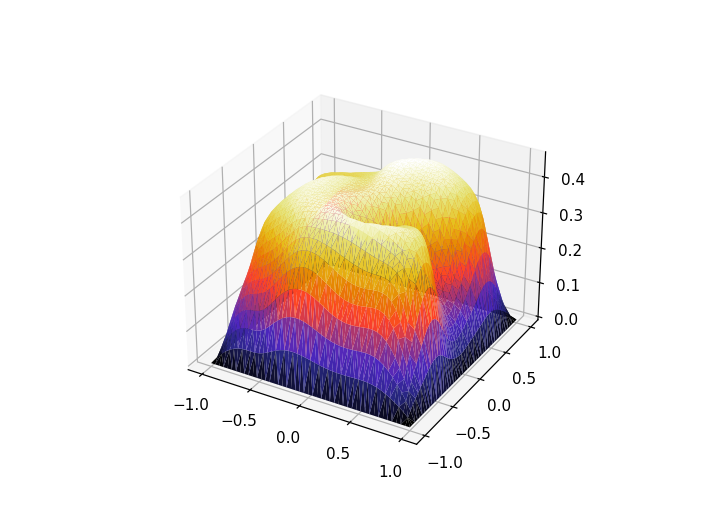

In [16]:
%matplotlib notebook
fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
# ax.plot_trisurf(x, y, w)
# ax.plot_trisurf(x, y, w, color='green', edgecolors='red', alpha=0.8)
ax.plot_trisurf(x, y, w, cmap=plt.cm.CMRmap)
# ax.plot_trisurf(x, y, w, cmap=plt.cm.hot)
# ax.scatter(x, y, w, c='red')

We will now prepare some 2D contour plots using retrieved data.
* Using `gridinterpolate` - Interpolate unstructured data.
* Using `tri.Triangulation` - Creates an unstructured triangular grid. Grid can be passed, or generated with Delaunay triangulation.

The idea is to cast the `x,y,w` arrays into a format that contour plots can handle. The easiest is to interpolate it into a proper `meshgrid`.

In [ ]:
#Mesh to which we will interpolate
ngridx = 6
ngridy = 6
xi = np.linspace(-1.0, 1.0, ngridx)
yi = np.linspace(-1.0, 1.0, ngridy)

Note on Reshaping. We can change shape of a numpy array with reshape.

In [ ]:
xi

In [ ]:
np.reshape(xi, (2,3))

In [ ]:
xi[None, :], yi[:, None]

In [17]:
import scipy.interpolate
# Using gridinterpolate
ngridx = 1000
ngridy = 1000
xi = np.linspace(-1.0, 1.0, ngridx)
yi = np.linspace(-1.0, 1.0, ngridy)

In [18]:
grint = scipy.interpolate.griddata((x, y), w,
                                   (xi[None, :], yi[:, None]),
                                   method='cubic')

<IPython.core.display.Javascript object>


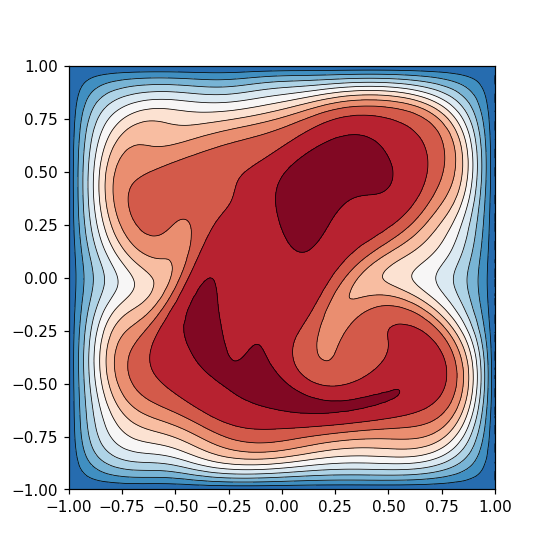

In [19]:
fig = plt.figure(figsize=(5,5))

plt.contour(xi, yi, grint, levels=14, linewidths=0.5, colors='k')
plt.contourf(xi, yi, grint, levels=14, cmap="RdBu_r")

But also with the `meshgrid`, since `griddata` formed a function of f(x,y)

In [ ]:
fig = plt.figure(figsize=(5,5))
xv, yv = np.meshgrid(xi, yi)
plt.contourf(xv, yv, grint, levels=14, cmap=plt.cm.coolwarm)
plt.contour(xv, yv, grint, levels=14, linewidths=0.5, colors='k')

Using `tri.Triangulation` and `TriInterpolator`.

In [ ]:
import matplotlib.tri as tri
# Linearly interpolate the data (x, y) on a grid defined by (xi, yi).
triang = tri.Triangulation(x, y)
# interpolator = tri.LinearTriInterpolator(triang, w)
interpolator = tri.CubicTriInterpolator(triang, w)
zv = interpolator(xv, yv)

In [ ]:
fig = plt.figure(figsize=(6,5))
ax = fig.gca()

plt.contour(xv, yv, zv, levels=14, linewidths=0.5, colors='k')
cntr = ax.contourf(xv, yv, zv, levels=14, cmap="RdBu_r")

fig.colorbar(cntr, ax=ax)
# ax.plot(x, y, 'ko', ms=1)
ax.set(xlim=(-1, 1), ylim=(-1, 1))

Finally, just pass the unordered coordinates to `tricontour`.

Additionally we will use a `Locator` from `matplotlib.ticker` to get 'nice' positions for the contour map:

In [14]:
import matplotlib.ticker
loc = matplotlib.ticker.MaxNLocator(9) # one of many possible choices
lvls = loc.tick_values(w.min(), w.max()) # levels

In [20]:
print(lvls)

[0.   0.06 0.12 0.18 0.24 0.3  0.36 0.42 0.48]


[(-1.0, 1.0), (-1.0, 1.0)]

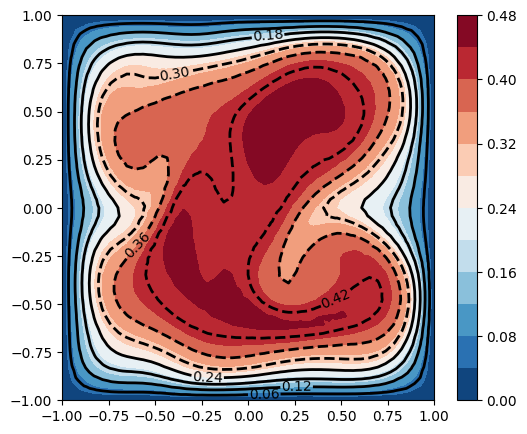

In [21]:
fig = plt.figure(figsize=(6,5))
ax = plt.gca()

cp = ax.tricontour(x, y, w, levels=lvls, linewidths=2, colors='k',
                   linestyles=np.where(lvls >= 0.3, "--", "-")) # Change line style according to level value
cntr2 = ax.tricontourf(x, y, w, levels=14, cmap="RdBu_r")

ax.clabel(cp, inline=True, fontsize=10) # add labels
fig.colorbar(cntr2, ax=ax)
ax.set(xlim=(-1, 1), ylim=(-1, 1))

# Things not always work ...
Unfortunately the particular ParaView API is not the most consistent one. 

In [ ]:
geom = VisItTecplotBinaryReader(FileName=['geom.plt'])
geom.PointArrayStatus = ['u', 'v', 'w']

In [ ]:
# create a new 'Slice'
slice1 = Slice(registrationName='Slice1', Input=geom)
slice1.SliceType = 'Plane'
slice1.HyperTreeGridSlicer = 'Plane'
slice1.SliceOffsetValues = [0.0]

# init the 'Plane' selected for 'SliceType'
slice1.SliceType.Origin = [0.0, 0.0, 12.566370964050293]

# init the 'Plane' selected for 'HyperTreeGridSlicer'
slice1.HyperTreeGridSlicer.Origin = [0.0, 0.0, 12.566370964050293]

# Properties modified on slice1.SliceType
slice1.SliceType.Normal = [0.0, 0.0, 1.0]

In [ ]:
slice_lok = paraview.servermanager.Fetch(slice1)

In [ ]:
point_coords = fromvtkarray(slice_lok.GetPoints().GetData())
slice_data = slice_lok.GetPointData()
w = fromvtkarray(slice_data.GetScalars('w'))
w = w[:,0]
npts = len(point_coords)
print(len(point_coords))
print(len(w))

In [ ]:
point_coords = fromvtkarray(slice_lok.GetBlock(0).GetBlock(0).GetPoints().GetData())
slice_data = slice_lok.GetBlock(0).GetBlock(0).GetPointData()
w = fromvtkarray(slice_data.GetScalars('w'))
w = w[:,0]
npts = len(point_coords)
print(len(point_coords))
print(len(w))